In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Muon_Decay as MD
import Meta_Muon_Decay as MMD
import numba as nb
import nu_nu_collisions as coll
from coll_varbins import C_short
import Constants as co
import Collision_approx as ca
import var_code_temp as vc

In [2]:
#constants relating to the sterile neutrino:
#D = 1./1.79**3          #a parameter that acts as a fraction of the number density of fermions?


# In[4]:


@nb.jit(nopython=True)
def I1(eps,x): #Energy Density
    numerator = (np.e**eps)*(eps**2)*((eps**2+x**2)**.5)
    denominator = np.e**((eps**2+x**2)**.5)+1
    return numerator/denominator

@nb.jit(nopython=True)
def I2(eps,x): #Pressure
    numerator = (np.e**eps)*(eps**4)
    denominator = ((eps**2+x**2)**.5)*(np.e**((eps**2+x**2)**.5)+1)
    return numerator/denominator

@nb.jit(nopython=True)
def dI1(eps,x): #Derivative of Energy Density
    numerator = (np.e**eps)*((eps**2+x**2)**.5)
    denominator = np.e**((eps**2+x**2)**.5)+1
    return (-x)*numerator/denominator

@nb.jit(nopython=True)
def dI2(eps,x): #Derivative of Pressure
    numerator = (np.e**eps)*3*(eps**2)
    denominator = ((eps**2+x**2)**.5)*(np.e**((eps**2+x**2)**.5)+1)
    return (-x)*numerator/denominator

eps_values, w_values = np.polynomial.laguerre.laggauss(10)

@nb.jit(nopython=True)
def calc_I1(x):
    return np.sum(w_values*I1(eps_values,x)) 

@nb.jit(nopython=True)
def calc_I2(x):
    return np.sum(w_values*I2(eps_values,x))

@nb.jit(nopython=True)
def calc_dI1(x):
    return np.sum(w_values*dI1(eps_values,x)) 

@nb.jit(nopython=True)
def calc_dI2(x):
    return np.sum(w_values*dI2(eps_values,x)) 

def calculate_integral(n,I,x): #n is number of steps to take, I is the function to integrate over, x is me/temp 
    return np.sum(w_values*I(eps_values,x))  



@nb.jit(nopython=True)
def diracdelta(Energy,E0,i,E_array):
    if i==0:
        boxsizeR = E_array[1] - E_array[0]
        boxsizeL = boxsizeR
    elif len(E_array)-i==1:
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = boxsizeL
    else: 
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = E_array[i+1] - E_array[i]
    
    x = E0 - Energy
    if E0 - 0.6 * boxsizeR <= Energy <= E0 - 0.4 * boxsizeR:
        x = E0 - (Energy + 0.5 * boxsizeR)
        A = 0.1 * boxsizeR
        return 2/(boxsizeR + boxsizeL) * (0.5 + 0.75 / A**3 * (x**3 / 3 - A**2 * x))
    elif E0 - 0.4 * boxsizeR <= Energy <= E0 + 0.4 * boxsizeL:
        return 2 / (boxsizeL + boxsizeR)
    elif E0 + 0.4 * boxsizeL <= Energy <= E0 + 0.6 * boxsizeL:
        x = E0 - (Energy - 0.5 * boxsizeL)
        A = 0.1 * boxsizeL
        return 2/(boxsizeR + boxsizeL) * (0.5 - 0.75 / A**3 * (x**3 / 3 - A**2 * x))
    else:
        return 0
    

@nb.jit(nopython=True)
def diracdelta2(Energy,Emin,Emax,E_B,gammaL,v,i,E_array): #E_array is the energy array, i is the index of the box we're at now
    #defining boxsizeL and boxsizeR:
    if i==0:
        boxsizeR = E_array[1] - E_array[0]
        boxsizeL = boxsizeR
    elif len(E_array)-i==1:
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = boxsizeL
    else: 
        boxsizeL = E_array[i] - E_array[i-1]
        boxsizeR = E_array[i+1] - E_array[i]
        
    r = 1/(2 * gammaL * v * E_B)
    if Emin - 0.5*boxsizeR <= Energy <= Emin:
        return r * (Energy + boxsizeR - Emin - 0.5 * boxsizeR) * 2 / (boxsizeR + boxsizeL)
    elif Emin <= Energy <= Emin + 0.5*boxsizeL:
        return r * (Energy + boxsizeR - Emin - 0.5 * boxsizeR) * 2 / (boxsizeR + boxsizeL)
    elif Emin + 0.5*boxsizeL <= Energy <= Emax - 0.5 * boxsizeR:
        return r
    elif Emax - 0.5* boxsizeR <= Energy <= Emax:
        return r * (Emax - (Energy-boxsizeL) - 0.5 * boxsizeL) * 2 / (boxsizeR + boxsizeL)
    elif Emax <= Energy <= Emax + 0.5*boxsizeL:
        return r * (Emax - (Energy - boxsizeL) - 0.5 * boxsizeL) * 2 / (boxsizeR + boxsizeL)
    else:
        return 0
        


@nb.jit(nopython=True)
def pB_other(mA,mB,mC):
    part1 = (mB**2-mA**2-mC**2)/(-2*mA)
    return (part1**2-mC**2)**.5

@nb.jit(nopython=True)
def energyandmomentum(mA,mB,mC,EA,theta): #theta is the angle at which the sterile neutrino decays
    pA = (EA**2-mA**2)**(1/2)
    pBo = pB_other(mA,mB,mC)
    pCo = pBo
    pxB = pBo*np.sin(theta)
    pxC = pCo*np.sin(theta+np.pi)
    pzB = .5*pA + (EA*pBo*np.cos(theta)/mA) + (pA*(mB**2 - mC**2)/(2*mA**2))
    pzC = .5*pA + (EA*pCo*np.cos(theta+np.pi)/mA) + (pA*(mC**2 - mB**2)/(2*mA**2))
    EB = (.5*EA) + (EA*(mB**2 - mC**2)/(2*mA**2)) + (pA*pBo*np.cos(theta)/mA)
    EC = (.5*EA) + (EA*(mC**2 - mB**2)/(2*mA**2)) + (pA*pCo*np.cos(theta+np.pi)/mA)
    return pxB,pxC,pzB,pzC,EB,EC

@nb.jit(nopython=True)
def energyB(mA,mB,mC,EA,theta): #NOTE: I keep putting 0 in for theta because it shouldn't matter yet, but it will soon
    pA = (EA**2-mA**2)**(1/2)
    pBo = pB_other(mA,mB,mC)
    EB = (.5*EA) + (EA*(mB**2 - mC**2)/(2*mA**2)) + (pA*pBo*np.cos(theta)/mA)
    return EB


@nb.jit(nopython=True)
def plasmaenergy(mA,mB,mC,EA,theta): #again, this function assumes that the neutrino is particle B
    pA = (EA**2-mA**2)**(1/2)
    pBo = pB_other(mA,mB,mC)
    pCo = pBo
    EB = (.5*EA) + (EA*(mB**2 - mC**2)/(2*mA**2)) + (pA*pBo*np.cos(theta)/mA)
    EC = (.5*EA) + (EA*(mC**2 - mB**2)/(2*mA**2)) + (pA*pCo*np.cos(theta+np.pi)/mA)
    return EC/(EB+EC) #Returns FRACTION of energy given to the plasma in the decay process


@nb.jit(nopython=True)
def trapezoid(y_array,x_array):
    total = np.sum((x_array[1:]-x_array[:-1])*(y_array[1:]+y_array[:-1])/2)
    return total

#@nb.jit(nopython=True)
def decay2(ms,angle):  #angle is the mixing angle of vs with active neutrinos
    numerator = 9*(co.Gf**2)*co.a_value*(ms**5)*((np.sin(angle))**2)
    denominator = 512*np.pi**4
    gamma = numerator/denominator
    return gamma

#@nb.jit(nopython=True)
def decay5(ms,angle): #angle is the mixing angle of the sterile neutrino with the active neutrinos
    part1 = (co.Gf**2)*(co.f_pi**2)/(16*np.pi)
    part2 = ms*((ms**2)-(co.mpi_neutral**2))*(np.sin(angle))**2
    gamma = part1*part2
    return gamma

#@nb.jit(nopython=True)
def decay6(ms,angle):
    part1 = (co.Gf**2)*(co.f_pi**2)/(16*np.pi)
    parentheses = ((ms**2) - (co.mpi_charged+co.me)**2)*((ms**2) - (co.mpi_charged-co.me)**2)
    part2 = ms * ((parentheses)**(1/2)) * (np.sin(angle))**2
    gamma = part1*part2
    return 2*gamma #because vs can decay into either pi+ and e- OR pi- and e+

#@nb.jit(nopython=True)
def decay7(ms,angle):
    part1 = (co.Gf**2)*(co.f_pi**2)/(16*np.pi)
    parentheses = ((ms**2) - (co.mpi_charged+co.mu)**2)*((ms**2) - (co.mpi_charged-co.mu)**2)
    part2 = ms * ((parentheses)**(1/2)) * (np.sin(angle))**2
    gamma = part1*part2
    return 2*gamma #because vs can decay into either pi+ and u- OR pi- and u+

#@nb.jit(nopython=True)
def tH(ms,angle):
    return 1/(decay2(ms,angle)+decay5(ms,angle)+decay6(ms,angle)+decay7(ms,angle))


# In[6]:


#@nb.jit(nopython=True)



def find_breaks(f, E5_index=0, E2_index=0):
    if (len(np.where(f < f_TINY)[0]) > 0):
        k_0 = np.where(f < f_TINY)[0][0]
    else: 
        k_0 = len(f) - 1
    if (len(np.where(f < f_MINI)[0]) > 0):
        k_1 = np.where(f < f_MINI)[0][0]
    else:
        k_1 = len(f) - 1
    if (len(np.where(f < f_SMALL)[0]) > 0):
        k_2 = np.where(f < f_SMALL)[0][0]
    else:
        k_2 = len(f) - 1
    
    for i in range(k_0, len(f)):
        if f[i] > f_TINY:
            k_0 = i+1
    for i in range(k_1,len(f)):
        if f[i] > f_MINI:
            k_1 = i+1
    for i in range(k_2,len(f)):
        if f[i] > f_SMALL:
            k_2 = i+1
            
    Echeck = [E5_index, E2_index]
    k_return = [k_0, k_1, k_2]
    for j in range(3):
        for i in range(2):
            if Echeck[i] - MIN_eps_BUFFER < k_return[j] <= Echeck[i]:
                k_return[j] += 2 * MIN_eps_BUFFER
            if Echeck[i] <= k_return[j] < Echeck[i] + MIN_eps_BUFFER:
                k_return[j] += MIN_eps_BUFFER
        for jj in range(j+1,3):
            if k_return[jj] < k_return[j] + MIN_eps_BUFFER:
                k_return[jj] = k_return[j] + MIN_eps_BUFFER
        if k_return[j] >= len(f):
            k_return[j] = len(f) - 1
    return k_return

# In[44]:


# This function assumes T_initial * a_initial = 1
# here, e_array is a required input.  Boxsize is calculated from that.
####################################################
##  12/28/20: include intermediate saves as optional
#def driver(ms,mixangle,a_init,y_init, e_array, eps_small, eps_buffer, dx, N_steps = 10, dN_steps = 10, pl_last = False, first = False, temp_fin=0):

@nb.jit(nopython=True)
def nH(time,Tcm,tao,D): #number density of decaying particles
    part1 = D*3*1.20206/(2*np.pi**2)
    part2 = Tcm**3*np.e**(-time/tao)
    return part1*part2
    
#@nb.jit(nopython=True)
def C_ve(p_array, Tcm, T, f,A_model,n_model):
    C_array = p_array**n_model * (f - ca.f_eq(p_array, T, 0))
    return - A_model * ca.n_e(T) * co.Gf**2 * T**(2-n_model) * C_array

    
#@nb.jit(nopython=True)
def f(a,y,p): #y is a vector with length 102 for now, y[-2] is temp and y[-1] is time, the rest are prob functions for now
    
    d_array = np.zeros(len(y))
    Tcm = 1/a #We always need T_initial * a_initial = 1
    T=y[-2]
    lene=int(p[-10])
    e_array=p[:lene]
    time=y[-1]
    fe=y[:lene]
    ms=p[-1]
    tao=p[-2]
    D=p[-3]
    mixangle=p[-4]
    kk=p[-7:-4]
    A_model=p[-8]
    n_model=p[-9]
    
    
    dtda_part2 = 2*np.pi/3
    E_B2 = energyB(ms,0,0,ms,0)
    E_B5 = energyB(ms,0,135,ms,0)
    
    #constants referrring to decay 6; the initial decay and the decay of the pion into the muon
    E_pi6 = energyB(ms,co.mpi_charged,co.me,ms,0) #energy of the charged pion from decay 6, theta is 0 because this is our chosen direction
    p_pi6 = (E_pi6**2 - co.mpi_charged**2)**(1/2) #momentum of charged pion from decay 6
    theta = 0
    E_B6 = energyB(co.mpi_charged,0,co.mu,co.mpi_charged,theta) #describes the energy of the muon neutrino from the pion decay from decay 6 in the other frame
    gammapi6 = E_pi6/co.mpi_charged
    v6 = p_pi6/E_pi6
    E_B6max = gammapi6*(E_B6 + (v6*E_B6))
    E_B6min = gammapi6*(E_B6 - (v6*E_B6))
    
    #constants referring to decay 7; the initial decay, the decay of the pion into the muon, and the decay of the FIRST muon 
    E_pi7 = energyB(ms,co.mpi_charged,co.mu,ms,0) #energy of the charged pion from decay 7, theta is 0 because this is our chosen direction
    Eu = ms-E_pi7 #Energy of the FIRST muon from decay 7, contains the rest of the energy that didn't go into the pion
    p_pi7 = (E_pi7**2 - co.mpi_charged**2)**(1/2) #momentum of charged pion from decay 7
    theta = 0
    E_B7 = energyB(co.mpi_charged,0,co.mu,co.mpi_charged,theta) #describes the energy of the muon neutrino from the pion decay from decay 7 in the other frame gammapi7 = E_pi7/c.mpi_charged
    gammapi7 = E_pi7/co.mpi_charged
    v7 = p_pi7/E_pi7
    E_B7max = gammapi7*(E_B7 + (v7*E_B7))
    E_B7min = gammapi7*(E_B7 - (v7*E_B7))
    
    #constants referring to the muon decay in decay 6:
    theta = 0
    E_mu6 = energyB(co.mpi_charged,co.mu,0,co.mpi_charged,theta) #describes the energy of the muon from the pion decay from decay 6 in the other frame
    p_mu6 = (E_mu6**2 - co.mu**2)**(1/2) #momentum of the muon in the other frame
    E_mumin6 = gammapi6*(E_mu6 - (v6*p_mu6))
    E_mumax6 = gammapi6*(E_mu6 + (v6*p_mu6))
    
    #constants referring to the SECOND muon decay in decay 7:
    theta = 0
    E_mu7 = energyB(co.mpi_charged,co.mu,0,co.mpi_charged,theta) #describes the energy of the muon from the pion decay from decay 7 in the other frame
    p_mu7 = (E_mu7**2 - co.mu**2)**(1/2) #momentum of the muon in the other frame
    E_mumin7 = gammapi7*(E_mu7 - (v7*p_mu7))
    E_mumax7 = gammapi7*(E_mu7 + (v7*p_mu7))


    dtda_part1 = co.mPL/(2*a)
    dtda_part3 = (T**4*np.pi**2)/15
    dtda_part4 = 2*T**4*calc_I1(co.me/T)/np.pi**2
    dtda_part6 = ms*nH(time,Tcm,tao,D)
    dtda_part7 = (Tcm**4/(2*np.pi**2))*trapezoid(fe*e_array**3,e_array)
    dtda = dtda_part1/(dtda_part2*(dtda_part3+dtda_part4+dtda_part6+dtda_part7))**.5
    d_array[-1] = dtda

    #df/da for the neutrinos and antineutrinos at epsilon = 0:
    d6b_e0 = 2*(1-co.x0**2)*decay6(ms,mixangle)*gammapi6*(co.mu**2)*(co.Gf**2)*E_mu6*nH(time,Tcm,tao,D)*dtda/(np.pi*MMD.gammanu((co.mu/2)*(1-co.x0**2)))
    d7b_e0 = 2*(1-co.x0**2)*decay7(ms,mixangle)*(Eu/co.mu)*(co.mu**2)*(co.Gf**2)*nH(time,Tcm,tao,D)*dtda/(np.pi*MD.gammanu((co.mu/2)*(1-co.x0**2)))
    d7c_e0 = 2*(1-co.x0**2)*decay7(ms,mixangle)*gammapi7*(co.mu**2)*(co.Gf**2)*E_mu7*nH(time,Tcm,tao,D)*dtda/(np.pi*MMD.gammanu((co.mu/2)*(1-co.x0**2)))
    d_array[0] = d6b_e0+d7b_e0+d7c_e0

    c = C_short(e_array*Tcm,fe,T,kk) 
    c += C_ve(e_array*Tcm, Tcm, T, fe,A_model,n_model)
    c *= dtda
    for i in range (1,lene): #because all the derivatives are dF/da except Temp and Time
        eps = e_array[i]
        coefficient = (2*np.pi**2)/(eps**2*Tcm**2*a**3)
        d2 = (decay2(ms,mixangle)*diracdelta((eps*Tcm),E_B2,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        d5 = (decay5(ms,mixangle)*diracdelta((eps*Tcm),E_B5,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        d6 = .5*(decay6(ms,mixangle)*diracdelta2((eps*Tcm),E_B6min,E_B6max,E_B6,gammapi6,v6,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        d6b = decay6(ms,mixangle)*(1/(2*gammapi6*v6*p_mu6))*MMD.u_integral(E_mumin6,E_mumax6,eps*Tcm,ms,mixangle)*nH(time,Tcm,tao,D)*a**3*dtda
        d7a = .5*(decay7(ms,mixangle)*diracdelta2((eps*Tcm),E_B7min,E_B7max,E_B7,gammapi7,v7,i,e_array*Tcm)*nH(time,Tcm,tao,D)*a**3)*dtda
        d7b = MD.v(Eu,eps*Tcm,ms,mixangle)*nH(time,Tcm,tao,D)*a**3*dtda #times two because there are 2 neutrinos coming out with the same energy distribution
        d7c = decay7(ms,mixangle)*(1/(2*gammapi7*v7*p_mu7))*MMD.u_integral(E_mumin7,E_mumax7,eps*Tcm,ms,mixangle)*nH(time,Tcm,tao,D)*a**3*dtda
        d_array[i] = coefficient*(d2+d5+d6+d6b+d7a+d7b+d7c) + c[i]#neutrinos only, antineutrinos not included

    df_array = d_array[:-2]*e_array**3/(2*np.pi**2) 
    dQda_part1 = ms*nH(time,Tcm,tao,D)*a**3*dtda/tH(ms,mixangle)
    dQda_part2 = Tcm**4*a**3*trapezoid(df_array,e_array)
    dQda = dQda_part1-dQda_part2

    dTda_constant1 = (4*np.pi**2/45)+(2/np.pi**2)*(calc_I1(co.me/T) + (1/3)*(calc_I2(co.me/T)))
    dTda_constant2 = 2*co.me*T*a**3/(np.pi**2)
    dTda_numerator1 = -3*a**2*T**3*dTda_constant1
    dTda_numerator2 = dQda/T
    dTda_denominator = (3*T**2*a**3*dTda_constant1) - (dTda_constant2*(calc_dI1(co.me/T))) - ((1/3)*dTda_constant2*(calc_dI2(co.me/T)))
    dTda = (dTda_numerator1 + dTda_numerator2)/dTda_denominator
    d_array[-2] = dTda

    return d_array


In [3]:
aaa=np.load("test_derivatives.npz",allow_pickle=True)
aaa.files

['ms',
 'mixing',
 'lifetime',
 'scale_factor',
 'y_inputs',
 'eps',
 'derivatives',
 'k',
 'An_model']

In [4]:
step=1

p=np.zeros(len(aaa['eps'][step])+10)

p[-10]=len(aaa['eps'][step])
p[:len(aaa['eps'][step])]=aaa['eps'][step]
p[-1]=aaa['ms']
p[-2]=vc.tH(aaa['ms'],aaa['mixing'])
p[-3]=1./1.79**3 
p[-4]=aaa['mixing']
p[-7:-4]=aaa['k'][step][:3]
p[-8]=aaa['An_model'][step][0]
p[-9]=aaa['An_model'][step][1]


In [5]:
check=f(aaa['scale_factor'][1],aaa['y_inputs'][1],p)


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


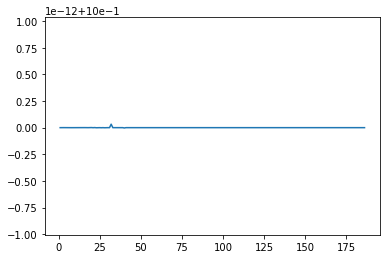

In [6]:
real=aaa['derivatives']
yval=np.zeros(len(check))
for i in range(len(check)):
    yval[i]=real[1][i]/check[i]
xval=np.linspace(1,len(check),len(check))

plt.figure()
plt.plot(xval,yval)
plt.show()

In [7]:
print(yval-1)

[ 0.00000000e+00  4.44089210e-16  2.22044605e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  2.22044605e-16  2.22044605e-16 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.44089210e-16
  0.00000000e+00  0.00000000e+00  2.22044605e-16  8.88178420e-16
 -3.33066907e-16  6.66133815e-16 -8.88178420e-16  0.00000000e+00
  0.00000000e+00 -7.77156117e-16  0.00000000e+00 -8.88178420e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.24185123e-14
  0.00000000e+00  0.00000000e+00  4.44089210e-16 -4.44089210e-16
  0.00000000e+00  2.22044605e-16  0.00000000e+00 -2.88657986e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000